In [1]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import numpy as np

In [2]:
import os
import pandas as pd
#os.getcwd()
df = pd.read_csv("../data/wyflows_w_response_and_geo.csv")
df.head()

,homeMSOA,workMSOA,workhome,metro,train,bus,taxi,motorcycle,car,cycle,...,otherqual,centheat,nrooms,wzclass,distance,response,disttrainstn,distcoachstn,distbusstop,distmway
0,E02002183,E02002184,0.0,0.0,0.01506,0.069277,0.0,0.0,0.743976,0.012048,...,0.028852,0.980225,5.9,4,2.684270,0.144439,0.437264,7.354263,0.021183,22.434402
1,E02002183,E02002185,0.0,0.0,0.12500,0.000000,0.0,0.0,0.812500,0.000000,...,0.028852,0.980225,5.9,6,7.265346,0.058454,0.270787,7.354263,0.031054,18.741927
2,E02002183,E02002186,0.0,0.0,0.00000,0.011628,0.0,0.0,0.941860,0.011628,...,0.028852,0.980225,5.9,6,4.906847,0.229892,1.636134,5.263695,0.483769,23.216051
3,E02002183,E02002187,0.0,0.0,0.00000,0.000000,0.0,0.0,0.916667,0.000000,...,0.028852,0.980225,5.9,4,6.938770,0.166186,0.935954,6.985427,0.328198,18.379430
4,E02002183,E02002188,0.0,0.0,0.00000,0.100000,0.0,0.0,0.700000,0.000000,...,0.028852,0.980225,5.9,5,4.595884,-0.002455,2.604336,3.576567,0.699492,19.114812


In [3]:
df.columns

Index(['homeMSOA', 'workMSOA', 'workhome', 'metro', 'train', 'bus', 'taxi',
       'motorcycle', 'car', 'cycle', 'walk', 'othertransp', 'npeople', '16-24',
       '25-34', '35-49', '50-54', '65-74', '75+', 'female', 'house0carpct',
       'house1carpct', 'house2carpct', 'house3carpct', 'house4carpct',
       'ppperhect', 'econactivpct', 'econinactivpct', 'vghealth', 'ghealth',
       'fhealth', 'bhealth', 'vbhealth', 'white', 'mixed', 'asian', 'black',
       'otherethn', 'noqual', 'aptshpqual', 'lev1qual', 'lev2qual', 'lev3qual',
       'lev4qual', 'otherqual', 'centheat', 'nrooms', 'wzclass', 'distance',
       'response', 'disttrainstn', 'distcoachstn', 'distbusstop', 'distmway'],
      dtype='object')

In [4]:
df = df[df.npeople >= 10]
df.index = list(range(df.shape[0]))

In [5]:
dropcols = ['homeMSOA','workMSOA','car','response','distance','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp']
droplevels = ['75+','house4carpct','econinactivpct','vghealth','white','otherqual']

Xfull = df.drop(dropcols+droplevels, axis=1).values
Yfull = df['response'].values

weightsfull = df['npeople'].values

predictors = list(df.drop(dropcols+droplevels, axis=1).columns)

In [6]:
# TO PREDICT CAR FRACTION DIRECTLY, INCLUDING DISTANCE AS A COVARIATE
#Xfull = df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).values
#Yfull = df['car'].values

#predictors = list(df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).columns)

In [7]:
# DO NOT USE THE FULL DATASET, SPLIT OFF A TRAINING SET BEFORE GOING FURTHER, AND NEVER USE THE FULL SET

import math

idx = list(range(Xfull.shape[0]))
np.random.seed(seed=5)
np.random.shuffle(idx)
np.random.seed(seed=None)

trainsetsize = math.floor(Xfull.shape[0]/2)
trainidx = idx[:trainsetsize]

X, Y = Xfull[trainidx,:], Yfull[trainidx]

In [8]:
predictors

['16-24',
 '25-34',
 '35-49',
 '50-54',
 '65-74',
 'female',
 'house0carpct',
 'house1carpct',
 'house2carpct',
 'house3carpct',
 'ppperhect',
 'econactivpct',
 'ghealth',
 'fhealth',
 'bhealth',
 'vbhealth',
 'mixed',
 'asian',
 'black',
 'otherethn',
 'noqual',
 'aptshpqual',
 'lev1qual',
 'lev2qual',
 'lev3qual',
 'lev4qual',
 'centheat',
 'nrooms',
 'wzclass',
 'disttrainstn',
 'distcoachstn',
 'distbusstop',
 'distmway']

In [9]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

#cross_valsets = StratifiedKFold(n_splits=2)
cross_valsets = KFold(n_splits=10)
for train_index, test_index in cross_valsets.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xval = X[train_index], X[test_index]
    Ytrain, Yval = Y[train_index], Y[test_index]

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xval = scaler.transform(Xval)

# We use X = X_train + X_test for the cross-validation runs, so scale X too (note: X is already a training set)
X = scaler.transform(X)

In [11]:
#import pickle

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    

    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    
 
    
#X = np.concatenate((Xtrain, Xtest), axis=0)
#Y = np.concatenate((Ytrain, Ytest), axis=0)

Split the data set into training, validation, and test sets.  
We will not touch the test set at all.

def TrainValTestSplit(X, Y, fracs_list=[0.7, 0.2, 0.1], shuffle=True, seed=42):
    """Split the samples x features Numpy array, X, into training, validation, and test sets as
    specified in fractions in list fracs_list (e.g. [0.6, 0.2, 0.2])
    
    Return Numpy arrays:
    Xtrain, Ytrain, Xval, Yval, Xtest, Ytest"""
    
    assert X.shape[0] == Y.shape[0]
    
    assert sum(fracs_list) == 1.0
    
    trainfrac, valfrac, testfrac = fracs_list
    idxs = np.arange(X.shape[0])

    if shuffle==True:
        np.random.seed(seed)
        np.random.shuffle(idxs)
        np.random.seed(None) # Reset to the default value in case numpy uses the seed later (somewhere below)

    trainidx = idxs[:int(trainfrac*len(idxs))]
    validx = idxs[int(trainfrac*len(idxs)):int(trainfrac*len(idxs))+int(valfrac*len(idxs))]
    testidx = idxs[int(trainfrac*len(idxs))+int(valfrac*len(idxs)):]

    #Xtrain, Ytrain = X[trainidx], Y[trainidx]
    #Xval, Yval = X[validx], Y[validx]
    #Xtest, Ytest = X[testidx], Y[testidx]
    #return Xtrain, Ytrain, Xval, Yval, Xtest, Ytest
    return trainidx,validx,testidx

trainidx, validx, testidx = TrainValTestSplit(X, Y, fracs_list=[0.6, 0.2, 0.2])

Xtrain, Ytrain = X[trainidx], Y[trainidx]
Xval, Yval = X[validx], Y[validx]
#Xtest, Ytest = X[testidx], Y[testidx]

The size of the training and validation sets, as well as the class labels and their distribution.

In [12]:
print(Xtrain.shape)
print(Xval.shape)

(6166, 33)
(685, 33)


Choose scaling. Standard scaling, minmax scaling, whitening, etc.

In [13]:
# Perform data whitening (make covariance matrix the identity matrix to remove auto-correlations)
def whitening(X):
    Xcentred = X - np.mean(X, axis=0)
    cov = np.dot(Xcentred.T, Xcentred) / float(Xcentred.shape[0])
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(Xcentred,U)
    # Xrot_reduced = np.dot(Xcentred, U[:,:100])
    Xwhite = Xrot / np.sqrt(S + 1e-5)
    return Xwhite

In [14]:
# Try whitening
#Xtrain = whitening(Xtrain)
#Xval = whitening(Xval)

Check for missing values. Impute if values are missing.

In [15]:
def fancyImpute(X_incomplete):
    """Imputation methods. Options: SimpleFill, DenseKNN, SoftImpute,
    IterativeSVD, MICE (ordinal variables only), MatrixFactorization,
    NuclearNormMinimization (too slow for large matrices)."""
    
    import fancyimpute as fi
    #from fancyimpute import (NuclearNormMinimization, BiScaler, DenseKNN)

    # rescale both rows and columns to have zero mean and unit variance
    biscaler = fi.BiScaler()
    X_incomplete_normalized = biscaler.fit_transform(X_incomplete)

    # use 3 nearest rows which have a feature to fill in each row's missing features
    #solver = fi.DenseKNN(k=3)
    solver = fi.SoftImpute()
    # Options for solver = NuclearNormMinimization
    X_filled_normalized = solver.complete(X_incomplete_normalized)
    X_filled = biscaler.inverse_transform(X_filled_normalized)

    #mse = ((X_filled[missing_mask] - X[missing_mask]) ** 2).mean()
    #print("MSE of reconstruction: %f" % mse)
    return X_filled

In [16]:
print(float(Xtrain[np.isnan(Xtrain)].shape[0])/Xtrain.shape[0])
print(float(Xval[np.isnan(Xval)].shape[0])/Xval.shape[0])

0.0
0.0


In [17]:
if Xtrain.any() == np.nan:
    Xtrain = fancyImpute(Xtrain)
if Xval.any() == np.nan:
    Xval = fancyImpute(Xval)

In [18]:
Ytrain = Ytrain.reshape((Ytrain.shape[0], 1))
print(Ytrain.shape)
Yval = Yval.reshape((Yval.shape[0], 1))
print(Yval.shape)

(6166, 1)
(685, 1)


Build the Multi-Layer Perceptron

In [19]:
import theano
from theano import tensor as T
#from theano.printing import debugprint

#theano.config.compute_test_value = 'warn' # default is 'off'
theano.config.compute_test_value = 'off'
#print theano.config.optimizer # default value is 'fast_run'
#print theano.config.exception_verbosity # default value is 'low'

import LasagneUpdateRules_Feb_2017 as lur

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [20]:
print(theano.__version__) # T.nnet.relu() activation function available only from Theano 0.7.1 onwards

0.9.0.dev-8e29249361c2177969d4101163b3dca4f1a7bec1


In [21]:
def floatX(array):
    """Convert array to Numpy array of a type supported by the CPU or GPU, accordingly"""
    return np.asarray(array, dtype=theano.config.floatX)

def init_weights(shape, frac=0.01):
    """Initialize weights randomly. Reduce weight size by factor to keep them closer to zero where gradient is largest
    and the learning is fastest at the beginning.
    This is Glorot initialisation, with a scaling factor."""
    #return theano.shared(floatX(frac*np.random.uniform(low=0.0, high=1.0, size=shape), borrow=True)
    #return theano.shared(floatX(np.sqrt(2/(shape[0]*shape[1]))*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)
    return theano.shared(floatX(np.sqrt(2)*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)

def init_bias(shape):
    """Initialize bias to array of zeros"""
    return theano.shared(value=np.zeros(shape, dtype=theano.config.floatX), borrow=True)

def init_ortho(shape):
    """Initialize weights to an orthogonal matrix. Output matrix is square,
    output matrix will only be of the requested dimensions if square"""
    #W = np.random.randn(*shape)
    W = np.random.normal(loc=0, scale=1, size=shape)
    u, s, v = np.linalg.svd(W)
    #return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    #return theano.shared(value=np.sqrt(2/(shape[0]*shape[1])).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)


#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
#from theano.sandbox.cuda.rng_curand import CURAND_RandomStreams as RandomStreams

def dropout(state_before, p=0.5):
    """Retain a fraction p of weights and set the other 1-p to zero"""
    #trng = T.shared_randomstreams.RandomStreams(np.random.randint(1000000, size=1))
    #trng = RandomStreams()
    trng = T.shared_randomstreams.RandomStreams()
    proj = T.cast((state_before * trng.binomial(state_before.shape, p=p, n=1, dtype=state_before.dtype))/p, theano.config.floatX)
    return proj

def to_onehot(array_column, n_classes=None):
    """Converts column array of integer labels (starting from 0) into
    one-hot encoding"""
    #array_column = np.asarray(array_column).flatten()
    if not np.equal(np.mod(array_column.any(), 1), 0):
        print("Problem: labels are not integers")
    if n_classes == None:
        # If no. of classes not given, deduce from data.
        # Can fail if not all possible classes found in vector.
        n_classes = len(np.unique(array_column))
    onehotcol = np.zeros((array_column.shape[0], n_classes))
    xmin = array_column.min()
    if np.equal(np.mod(array_column.all(), 1), 0) and xmin!=0:
        print("Labels don't start from 0, shifted them")
        array_column_shifted = array_column-xmin
        #print(array_column_shifted)
        for i in range(array_column_shifted.shape[0]):
            #print(i, array_column_shifted[i])
            onehotcol[i, int(array_column_shifted[i])] = 1
    else:
        for i in range(array_column.shape[0]):
            onehotcol[i, int(array_column[i])] = 1
    return onehotcol

import pickle, os

def save_model(parameters, filename):
    """Serialise Theano shared variables to disk"""
    dirname = 'saved_model'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(os.path.join(dirname, filename+'.pkl'), 'wb') as fb:
        for p in parameters:
            pickle.dump(p.get_value(borrow=True),fb, -1)

Convert to 1-of-N representation for N > 2 class classification.

In [22]:
#Ytrain = to_onehot(Ytrain)

Convert to GPU-friendly single precision floats

In [23]:
Xtrain = floatX(Xtrain)
Ytrain = floatX(Ytrain)

Xval = floatX(Xval)
Yval = floatX(Yval)

Convert data to theano shared variable type to make optimal usage of GPU memory.

In [24]:
Xtraintheano = theano.shared(Xtrain, borrow=True)
Ytraintheano = theano.shared(Ytrain, borrow=True)

Find greatest common divisor between training and validation sets, to use as batchsize to ensure prediction on full validation set. If this is not important, override batch size manually below.

In [25]:
from math import gcd

batchsize = gcd(Xtrain.shape[0], Xval.shape[0])

print(batchsize)

1


In [26]:
batchsize = 64

In [27]:
nfeats = Xtrain.shape[1]
widhidlay = nfeats # To ensure autoencoder input and output have the same dimensions, as they must.

Build and train the Stacked Denoising Auto-encoders for unsupervised pre-training of the lower (non-output) layers of the neural network.

In [28]:
n_epochs_pretrain = 1
n_pretrain_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)

In [29]:
X = T.matrix(name='X')
Y = T.matrix(name='Y')
index = T.lscalar()

def pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre):
    X = dropout(X, p=0.5)
    h1 = T.nnet.sigmoid(T.dot(X,w_h1_pre) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre.T) + b_h2_pre)
    return h2

In [30]:
w_h1_pre = init_weights((nfeats, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))

Xpred = pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre)


L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) + 0.0001*L1 + 0.0001*L2
#cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain1 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain1(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output1 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano1 = theano.shared(floatX(ae_output1), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [31]:
print(ae_outputtheano1.get_value())

[[-0.83813047  0.70977199 -1.60449243 ..., -0.79601294  1.62058926
   0.20727515]
 [-1.05729413  3.9174006  -0.74007773 ..., -0.01920797  0.89235902
  -0.33338618]
 [-0.98683798  0.19386637 -1.75266623 ..., -0.28414047 -2.56543422
  -0.14806913]
 ..., 
 [ 0.40721586 -0.72062951 -0.74205875 ..., -0.55966949 -1.32054055
   2.09890962]
 [ 0.67388111  0.16929823 -0.67928219 ..., -0.6062941   0.55054086
   0.13000736]
 [ 0.39300692  0.74590892 -0.17887393 ..., -0.32321969  1.18540072
  -1.33778954]]


In [32]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights) + b_h1_pre)
    h1 = dropout(h1, p=0.5)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre) + b_h2_pre)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre.T) + b_h3_pre)
    return h3

Xpred = pretrain_model(X, ae_outputtheano1, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre)

L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) + 0.0001*L1 + 0.0001*L2
#cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain2 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain2(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output2 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano2 = theano.shared(floatX(ae_output2), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [33]:
print(ae_outputtheano2.get_value())

[[-0.03385478 -0.02924463 -0.35270292 ..., -0.26751664 -0.1493063
   0.1057976 ]
 [-0.27842644  0.25774649  0.36597937 ..., -0.02812685 -0.29077944
  -0.01271325]
 [ 0.28339145 -0.23951264 -0.21865915 ..., -0.11345239  0.44307467
   0.2932744 ]
 ..., 
 [-0.30520928 -0.5055629   0.12449026 ..., -0.16191275 -0.33319798
  -0.31993151]
 [-0.01151933  0.16026473 -0.24849418 ..., -0.39000115 -0.52053106
  -0.19457583]
 [ 0.05893066 -0.78345078 -0.10129798 ...,  0.18752538 -0.10837339
  -0.25210652]]


In [34]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))
b_h4_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights1, previous_weights2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights1) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,previous_weights2) + b_h2_pre)
    h2 = dropout(h2, p=0.5)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre) + b_h3_pre)
    h4 = T.nnet.sigmoid(T.dot(h3,w_h1_pre.T) + b_h4_pre)
    return h4

Xpred = pretrain_model(X, ae_outputtheano1, ae_outputtheano2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre)

L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) + 0.0001*L1 + 0.0001*L2

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain3 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain3(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output3 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano3 = theano.shared(floatX(ae_output3), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [35]:
print(ae_outputtheano3.get_value())

[[-0.12216199 -0.18881938  0.27217519 ...,  0.37874335  0.06307828
   0.05537027]
 [-0.24017037  0.09536848  0.01306337 ...,  0.07506616 -0.13148348
   0.50488919]
 [ 0.25509378 -0.14524503 -0.1691923  ...,  0.31549391  0.09008107
  -0.40361589]
 ..., 
 [-0.22152919  0.13474122 -0.06246571 ..., -0.14099987  0.3490639
  -0.10862285]
 [-0.13869655 -0.38629323  0.08522    ...,  0.06069566 -0.24257779
   0.06297341]
 [ 0.02418379 -0.02370573  0.07729611 ...,  0.03606199 -0.16829517
   0.26310587]]


Build the neural network itself.

In [36]:
#X = T.matrix(name='X')
#Y = T.matrix(name='Y')
#index = T.lscalar()

dropout_p = 0.8
relu_alpha = 0.0

def model_train(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    #o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    o = T.dot(h3,w_o) + b_o
    return o

def model_test(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    #h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    #h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    #o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    o = T.dot(h3,w_o) + b_o
    return o


nfeats = Xtrain.shape[1]
widhidlay = nfeats
nclasses = 1
#nclasses = len(np.unique(Ytrain))  # Use 1 for binary classification or regression

# 3 hidden layers, initialise the weights and biases
#w_h1 = init_weights((nfeats, widhidlay))
w_h1 = ae_outputtheano1
b_h1 = init_bias((batchsize, widhidlay))
#w_h2 = init_ortho((widhidlay, widhidlay))
w_h2 = ae_outputtheano2
b_h2 = init_bias((batchsize, widhidlay))
#w_h3 = init_ortho((widhidlay, widhidlay))
w_h3 = ae_outputtheano3
b_h3 = init_bias((batchsize, widhidlay))
w_o = init_weights((widhidlay, nclasses))
b_o = init_bias((batchsize, nclasses))

# Runs the NN and outputs the result from its output node
#yprobs_train = model_train(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
#yprobs_test = model_test(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
ypred_train = model_train(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
ypred_test = model_test(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)


# Predicted label is 1 if its probability is >=0.5, and 0 otherwise.
#ypred = (yprobs >= 0.5)


#ypred_train = T.argmax(yprobs_train)
#ypred_test = T.argmax(yprobs_test)

#ypred_train = T.switch(T.lt(yprobs_train, 0.5), 0, 1)
#ypred_test = T.switch(T.lt(yprobs_test, 0.5), 0, 1)

#ypred_train = T.switch(T.lt(yprobs_train, 0.07), 0, 1)
#ypred_test = T.switch(T.lt(yprobs_test, 0.07), 0, 1)

#err = T.mean(T.neq(ypred, Y))

params = [w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o]


#L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) 
#L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) 

L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) + T.sum(T.abs_(w_h1)) + T.sum(T.abs_(w_o))
L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) + T.sum(T.sqr(w_h1)) + T.sum(T.sqr(w_o))

    
#cost = T.mean(T.nnet.categorical_crossentropy(yprobs_train, Y)) + 0.01*L1 + 0.01*L2
#cost = -(Y*T.log(yprobs_train) + (1-Y)*T.log(1-yprobs_train)).mean() + 0.001*L1 + 0.001*L2
#cost = T.mean(T.nnet.binary_crossentropy(yprobs, Y)) + 0.01*L2
#cost = T.mean(T.sqr(yprobs_train-Y))

cost = T.mean(T.sqr(ypred_train-Y)) + 0.0001*L1 + 0.0001*L2
#cost = T.mean(T.nnet.binary_crossentropy(ypred_train, Y)) + 0.0001*L1 + 0.0001*L2
#cost = T.mean(Y*T.log(ypred_train) + (1-Y)*T.log(1-ypred_train)) + 0.0001*L1 + 0.0001*L2

#updates = lur.sgd(cost,params,learning_rate=0.001)
#updates = lur.adagrad(cost, params, learning_rate=0.01)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.001)
#updates = lur.adamax(cost,params,learning_rate=0.01)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.01)




train = theano.function(
        inputs=[index],
        outputs=cost,
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize],
            Y: Ytraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Xvaltheano = theano.shared(Xval, borrow=True)
Yvaltheano = theano.shared(Yval, borrow=True)

predict = theano.function(
        inputs=[index],
        #outputs=yprobs,
        #outputs=(yprobs,ypred),
        #outputs=(cost,yprobs,err),
        outputs=ypred_test,
        #outputs=(yprobs_test,ypred_test),
        allow_input_downcast=True,
        givens={
            X: Xvaltheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Train the neural network.

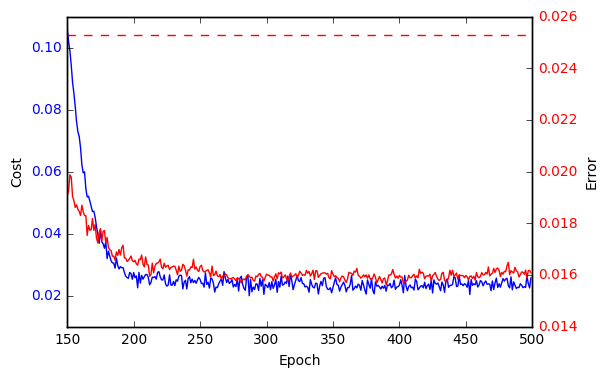

Training took 30.8 seconds.


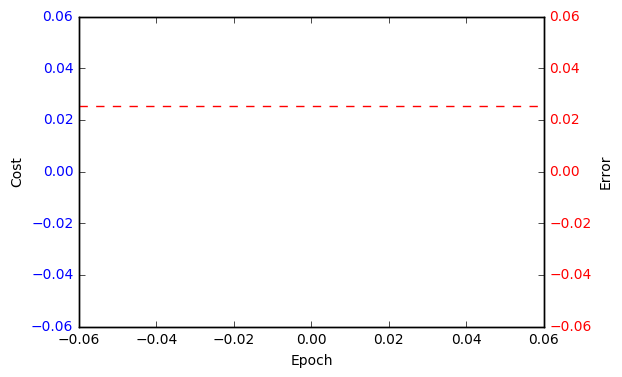

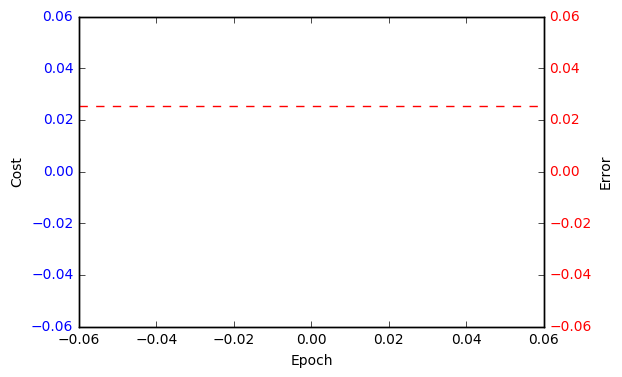

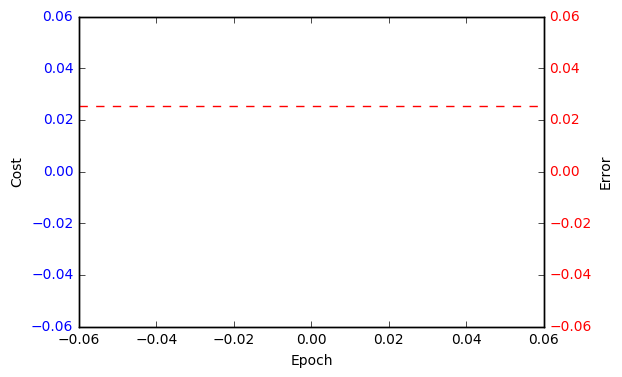

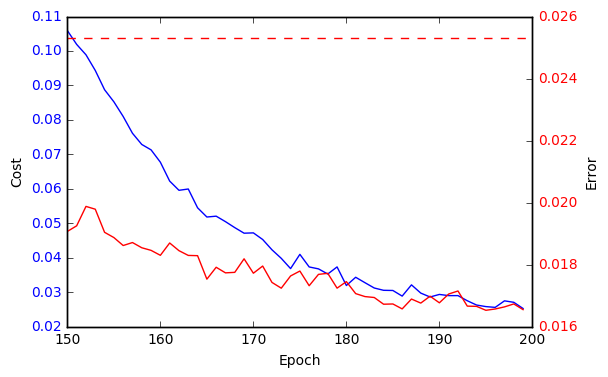

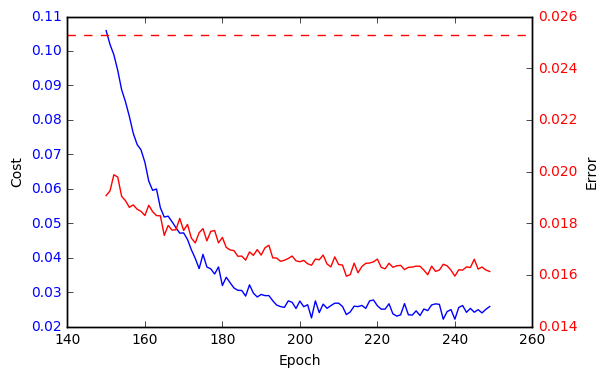

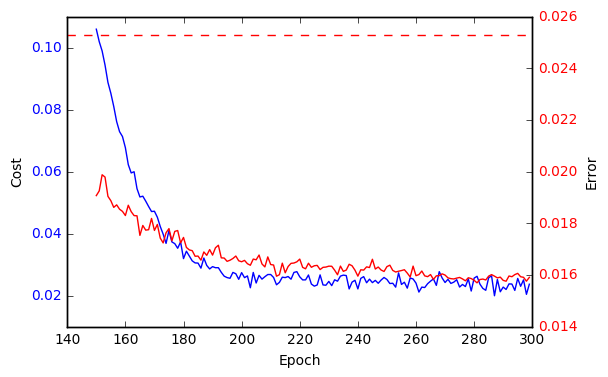

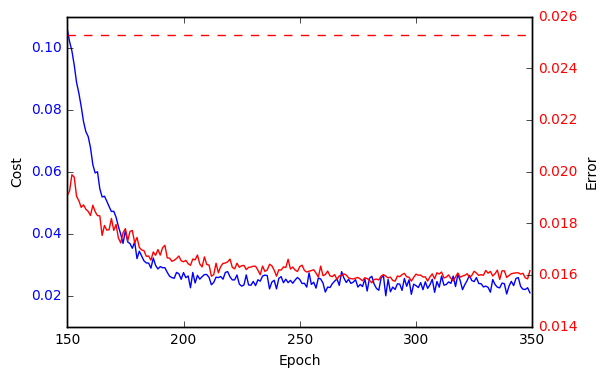

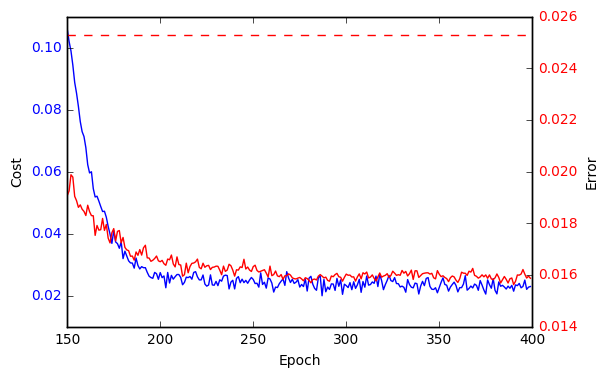

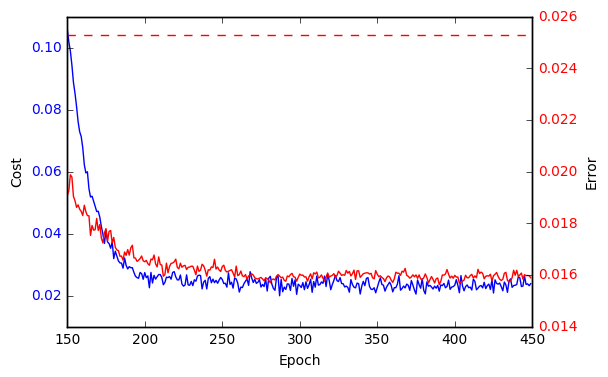

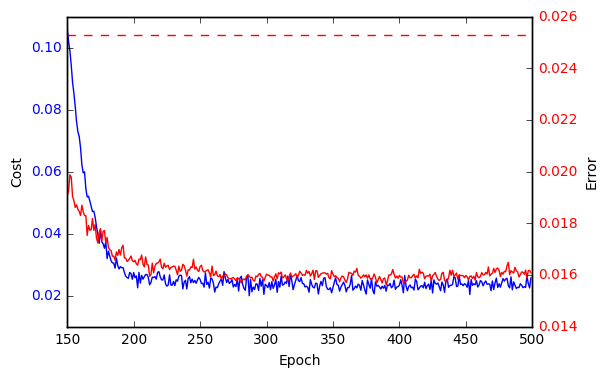

In [37]:
import time
from scipy.stats import mode

n_train_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)
n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

n_epochs = 500

plt.ion()

start = time.time()
epochs = []
costs = []
errors = []
#randomerror = 1 - 1.0/len(np.unique(Yval))
#randomerror = np.mean()
#mostcommonerror = np.mean(Yval != mode(Yval)[0][0]) #error from always predicting most common class
for epoch in range(n_epochs):
    epochstart = time.time()
    ypreds = np.empty((batchsize*n_test_batches, 1), dtype=float)
    #yprobs = np.empty((batchsize*n_test_batches, 1), dtype=float)
    for batchidx in range(n_train_batches):
        batchcost = train(batchidx)
        if batchcost == np.nan:
            print("NaN cost. Exiting. Try lowering the learning rate.")
            break
    for batchidx in range(n_test_batches):
        #batchyprob, batchypred = predict(batchidx)
        batchypred = predict(batchidx)
        #yprobs[batchsize*batchidx:batchsize*(batchidx+1)] = batchyprob
        ypreds[batchsize*batchidx:batchsize*(batchidx+1)] = batchypred
    #print("Epoch: {0}, runtime: {1}, cost: {2}".format(epoch, time.time()-epochstart, batchcost))
    epochs.append(epoch)
    costs.append(batchcost)
    
    epochYtest = Yval[:ypreds.shape[0]]
    #if epochYtest.shape[1]>1: #If Yval is in one-hot form change back to single int to compare with ypred
    #    epochYtest = np.argmax(epochYtest, axis=1)
    
    epochErr = np.mean((epochYtest - ypreds)**2)
    #epochAcc = np.mean(epochYtest == ypreds)
    #epochErr = np.mean(epochYtest != ypreds)
    
    errors.append(epochErr)
    
    randomerror = np.mean((epochYtest - np.mean(Yval))**2)
    
    #if epochErr < randomerror and epochErr < mostcommonerror:
    #    save_model(params, 'model-epoch_'+str(epoch))
    if (epoch+1)%(n_epochs/10)==0:
        # If error drops precipitously at the beginning the y-scale of the plots is large and ruins plots
        # remove first epochs to avoid this
        epochsplot = epochs[150:]
        costsplot = costs[150:]
        errorsplot = errors[150:]
        fig, ax = plt.subplots()
        ax.plot(epochsplot,costsplot, 'b-')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Cost")
        for tl in ax.get_yticklabels():
            tl.set_color('b')

        ax1 = ax.twinx()
        ax1.plot(epochsplot, errorsplot, 'r-')
        ax1.set_ylabel("Error")
        ax1.axhline(randomerror, color='r', linestyle='dashed')
        #ax1.axhline(mostcommonerror, color='r', linestyle='dotted')
        for tl in ax1.get_yticklabels():
            tl.set_color('r')    

        epochtime = time.time()-epochstart
        print("Epoch runtime: {0:.3g}s".format(epochtime), end="\r")

        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    if epoch == n_epochs-1:
        save_model(params, 'model_'+str(np.mean(errors[150:])))
    
#    if len(errors) >= 40: # Run at least for 40 epochs
#        temperrs = np.asarray(errors)
#        if epochErr >= temperrs[-30] - temperrs[-30:].std():
#            break # If error hasn't improved by 1 SD in 30 epochs, stop
    
    #print("Epoch: {0}\tAccuracy: {1:.4g}\tError: {2:.3g}\tCost: {3:.6g}\tRuntime: {4:.3g}".format(epoch, epochAcc, epochErr, batchcost, epochtime))

end = time.time()

print("Training took {0:.3g} seconds.".format(end-start))

Inspect output: predicted probabilities and final weight matrices.

In [38]:
#print(yprobs[:100])

In [39]:
w_h1.get_value()

array([[  3.98839038e-05,  -6.10920601e-03,  -1.60832584e-04, ...,
         -4.17457614e-03,   2.58373559e-01,  -6.27899717e-05],
       [  5.30734193e-04,   1.54582500e-01,   2.52057907e-05, ...,
         -1.22010838e-02,   7.02696037e-04,   1.27939682e-04],
       [  1.57766044e-04,  -3.66877504e-02,   1.82109739e-04, ...,
         -4.71491716e-04,  -1.59055348e-02,   1.35527152e-04],
       ..., 
       [  6.95816925e-05,  -1.13404626e-02,   2.11018734e-04, ...,
          2.65096892e-02,   8.65846034e-03,  -3.12174059e-04],
       [  8.64993490e-06,  -3.69056081e-03,  -1.02646176e-04, ...,
          1.05884999e-01,  -4.81032254e-03,   2.20762275e-04],
       [ -1.77701120e-04,  -1.09246117e-03,   1.19220986e-05, ...,
         -3.23438318e-03,   6.39876351e-02,   1.17615986e-04]], dtype=float32)

In [40]:
w_h2.get_value()

array([[ -6.73655959e-05,   7.47997663e-04,   8.93501856e-05, ...,
          5.10352664e-04,  -6.03211811e-03,   7.65442019e-05],
       [  1.61642500e-04,   1.33041516e-01,  -7.70559855e-05, ...,
         -6.10486837e-03,   3.65619957e-02,   2.17969966e-04],
       [ -1.96158857e-04,  -8.66255665e-04,   1.92189211e-04, ...,
          1.90034951e-03,  -1.46448310e-03,   1.31085108e-04],
       ..., 
       [  1.32609057e-05,  -1.47978067e-01,  -2.35816638e-04, ...,
          5.85072732e-04,  -6.95867762e-02,   1.14095688e-04],
       [  9.36939323e-05,  -2.69469735e-03,   2.27315904e-05, ...,
         -1.43132418e-01,   3.88065986e-02,   2.17970053e-04],
       [ -1.96174762e-04,  -8.31144716e-05,  -1.96174660e-04, ...,
          3.50938033e-04,  -2.31777434e-03,   3.33003263e-04]], dtype=float32)

In [41]:
w_h3.get_value()

array([[  1.14094932e-04,  -5.63773647e-05,  -9.13382537e-05, ...,
          6.09252966e-05,   9.88460233e-05,   1.96167995e-04],
       [ -6.34878961e-06,  -6.73590621e-05,   2.17969529e-04, ...,
          1.40121803e-04,  -1.09423992e-04,  -1.30410030e-04],
       [ -7.46982405e-05,   1.25902268e-04,  -1.30413959e-04, ...,
         -7.65535515e-05,   8.93385586e-05,  -6.73635950e-05],
       ..., 
       [  1.82742777e-04,   1.30410539e-04,  -1.25900595e-04, ...,
          9.00866435e-05,  -8.06552562e-05,   7.65385994e-05],
       [  1.31087581e-04,  -7.65468212e-05,  -7.65518271e-05, ...,
          6.76111813e-05,   8.37585394e-05,  -1.07920001e-04],
       [  9.88460451e-05,   4.97172950e-05,   7.46979349e-05, ...,
         -1.52659879e-04,  -2.02659474e-04,  -2.17969995e-04]], dtype=float32)

In [42]:
w_o.get_value()

array([[ -2.17970111e-04],
       [ -1.14095470e-04],
       [ -8.93248725e-05],
       [  7.46981677e-05],
       [  9.03317392e-01],
       [ -1.30412125e-04],
       [ -1.30307919e-04],
       [ -5.88521012e-04],
       [ -1.82743781e-04],
       [  6.09243143e-05],
       [ -6.73812756e-05],
       [  1.34083704e-04],
       [  2.37064529e-03],
       [  2.37548887e-03],
       [ -6.81840628e-03],
       [  2.03292817e-03],
       [  4.89608617e-04],
       [  7.41110009e-04],
       [ -4.79576236e-04],
       [ -7.65458608e-05],
       [  9.48118686e-05],
       [ -8.93367047e-04],
       [  1.34342816e-03],
       [ -1.18592288e-05],
       [ -4.84049000e-04],
       [ -7.46876176e-05],
       [  1.18079915e-05],
       [ -9.64526892e-01],
       [  1.96978776e-03],
       [ -2.74569960e-03],
       [  5.20569365e-03],
       [  1.14254428e-04],
       [  2.43738526e-04]], dtype=float32)

Analyse the final performance.

In [43]:
errors = np.asarray(errors)
print("Minimum error at epoch {0}: {1:.3g} (Accuracy: {2:.4g})".format(errors.argmin(), errors[errors.argmin()], 1-errors[errors.argmin()]))

Minimum error at epoch 390: 0.0156 (Accuracy: 0.9844)


In [44]:
np.mean(errors[150:])

0.016267938682433588

In [45]:
n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

results = np.empty((batchsize*n_test_batches, 1),dtype=float)
#resultprobs = np.empty((batchsize*n_test_batches, 1),dtype=float)
for batchidx in range(n_test_batches):
    #resultprobs[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[0]
    #results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[1]
    results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)#[0]
    
results = np.asarray(results, dtype=float)
results = results.flatten()

In [46]:
results[:10]

array([ 0.01374285,  0.12555385, -0.1284638 ,  0.09636641,  0.18049772,
       -0.06118508, -0.0598638 ,  0.07481004, -0.18109956,  0.11602804])

In [47]:

#Yval_testing = Yval_testing.reshape(Yval_testing.shape[0],)

Yval_testing = Yval[:results.shape[0]]
#Xval_testing = Xval[:results.shape[0]]

#if Yval_testing.shape[1] > 0:
#    Yval_testing = np.argmax(Yval_testing, axis=1
Yval_testing = Yval_testing.flatten()
Yval_testing = np.asarray(Yval_testing, dtype=float)

Yval_testing[:10]

array([ 0.05102158,  0.15185519, -0.1141959 ,  0.23546767,  0.18621616,
       -0.22246674, -0.15530728,  0.12914234, -0.06180431,  0.03206129])

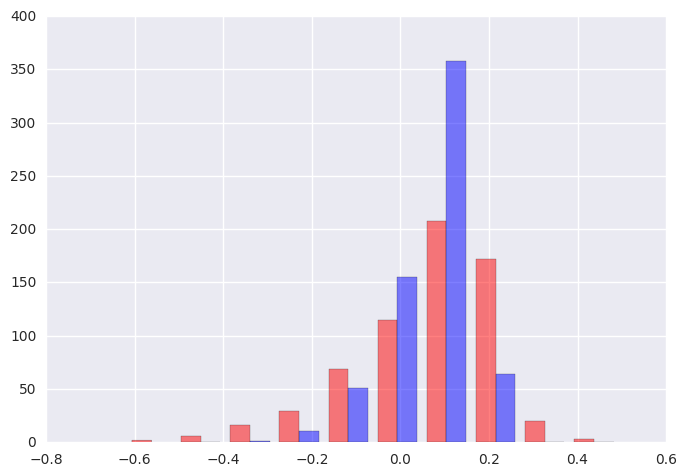

In [48]:
import seaborn as sns
plt.hist([Yval_testing, results], color=['r','b'], alpha=0.5)
plt.show()

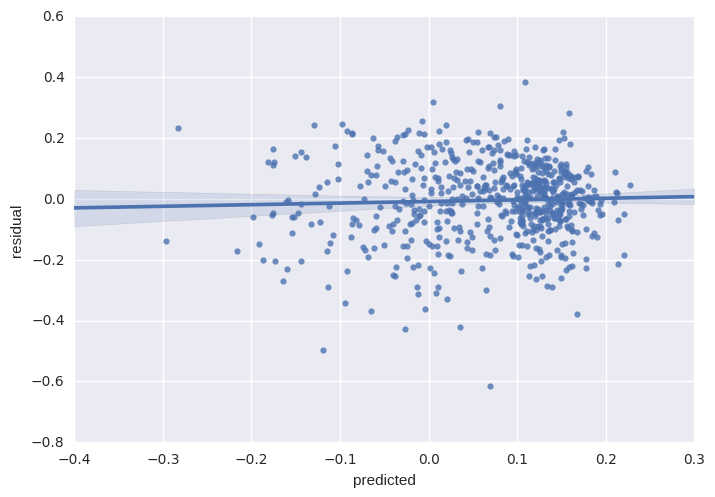

In [49]:
cols = ["observed","predicted"]
plotdf = pd.DataFrame(columns=cols)
plotdf.loc[:, "observed"] = Yval_testing
plotdf.loc[:, "predicted"] = results
plotdf.loc[:, "residual"] = plotdf.loc[:, "observed"] - plotdf.loc[:, "predicted"]

sns.regplot(x="predicted", y="residual", data=plotdf)
plt.show()

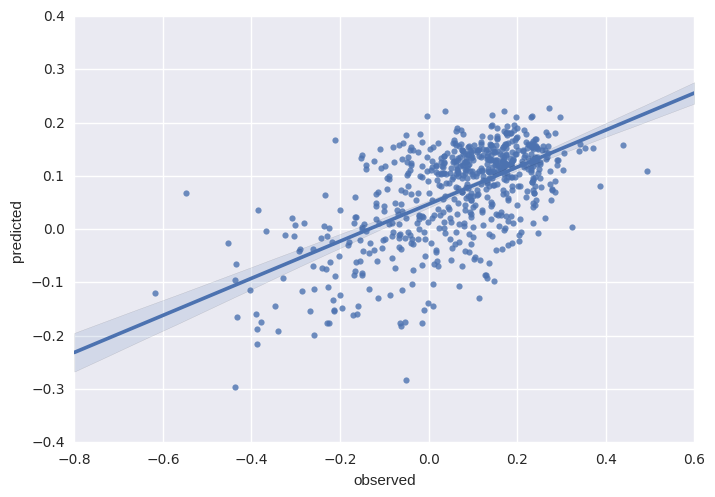

In [50]:
sns.regplot(x="observed", y="predicted", data=plotdf)
plt.show()

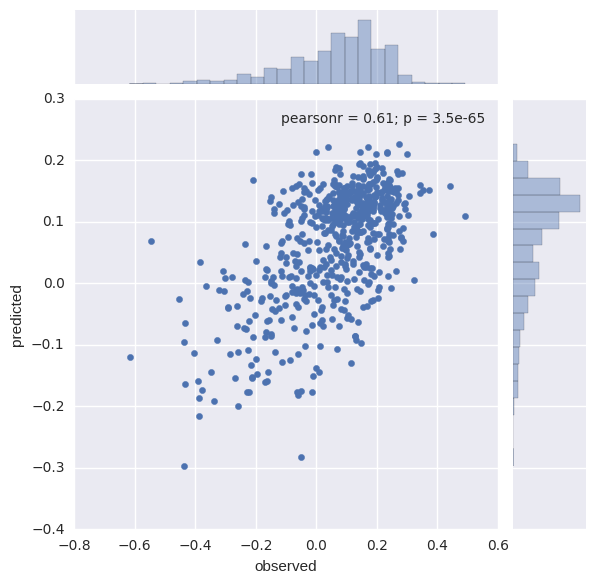

In [51]:
sns.jointplot(x="observed", y="predicted", data=plotdf)
plt.show()

In [52]:
from sklearn.metrics import r2_score

r2_score(plotdf[["observed"]], plotdf[["predicted"]])

0.36419121726278514

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(plotdf[["observed"]], plotdf[["predicted"]])

0.01608178109458356